In [2]:
!pip install imblearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.6/235.6 kB 4.5 MB/s eta 0:00:00a 0:00:01


In [13]:
! pip install wordcloud

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.0/169.0 kB 4.8 MB/s eta 0:00:00


In [14]:
import pandas as pd
import numpy as np
import os
import sys
from dataclasses import dataclass, field
sys.path.append('..')
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler
from utils import *
from logger import logging
from exception import CustomException

# appending a path 

import warnings
warnings.filterwarnings("ignore")

In [4]:
# Config
trained_model_file_path = "./artifacts/model.pkl"
preprocessor_file_path = "./artifacts/preprocessor.pkl"

### Load and use the best model already trained

In [6]:
model = load_object(trained_model_file_path)
preprocessor = load_object(preprocessor_file_path)

texte = 'I hate you'
y_hat = model.predict(preprocessor.transform([texte]))[0]
y_hat

CustomException: Error occured in python script name [/Users/bensidhoum-a/Documents/GitHub/PROJET-REDS/src/notebooks/../utils.py] line number [60] error message [node array from the pickle has an incompatible dtype:
- expected: {'names': ['left_child', 'right_child', 'feature', 'threshold', 'impurity', 'n_node_samples', 'weighted_n_node_samples', 'missing_go_to_left'], 'formats': ['<i8', '<i8', '<i8', '<f8', '<f8', '<i8', '<f8', 'u1'], 'offsets': [0, 8, 16, 24, 32, 40, 48, 56], 'itemsize': 64}
- got     : [('left_child', '<i8'), ('right_child', '<i8'), ('feature', '<i8'), ('threshold', '<f8'), ('impurity', '<f8'), ('n_node_samples', '<i8'), ('weighted_n_node_samples', '<f8')]]

### Or train your own model

In [7]:
# Load data
df = pd.read_csv('../data/toots_labeled.csv')
df.head()

,_id,user,content,y
0,111760629678894298,t3n,"Urheberrechtsverletzung, geschmacklos oder doc...",0
1,111760629646594273,wlbolm,A few months ago I couldn't help myself and wr...,0
2,111760629635323004,risahana,火曜日が終わると水曜日でここに帰ってくる,0
3,111760629635186542,tuburejp,鼻血が出ている（何の報告）そして「名探偵炎山」の黒幕が突然決まってしまったから4で黒幕と対決...,0
4,111760629626407296,owls,a windchill of -40F is not compatible with hum...,0


In [4]:
np.unique(df['y'], return_counts=True)
# -> imbalanced classes

(array([0, 1], dtype=int64), array([9747,   97], dtype=int64))

In [6]:
# Use a preprocessor (tf-idf vectorizer in this case)
preprocessor = load_object('../artifacts/preprocessor.pkl')

X, y = df['content'], df['y']
X_emb = preprocessor.fit_transform(X)

# Initialize the RandomOverSampler
oversampler = RandomOverSampler(sampling_strategy='auto', random_state=42)

# Fit and transform your dataset
X_resampled, y_resampled = oversampler.fit_resample(X_emb, y)

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

np.unique(y_train, return_counts=True) # -> Balanced classes

(array([0, 1], dtype=int64), array([7788, 7807], dtype=int64))

### Models to be trained and fitted

In [7]:
models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(),
    "SVM": SVC(),
    "Naive Bayes": MultinomialNB(),
}

params = {
    "Logistic Regression": {
        'C': [0.1, 1, 10],
    },
    "Random Forest": {
        'n_estimators': [10, 50, 100],
    },
    "SVM": {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf'],
    },
    "Naive Bayes": {},
}

### Training loop
Our experimental protocol is obtained by running the following tasks:
- Use of GridSearchCV (A grid searching technique combined with a cross validation procedure for evaluation).
- Use of multiple metrics (maybe think of adding the roc-auc).
- Selection of the best model.

In [8]:
model_report = {}
fitted_models = {}
for name, model in models.items():
    logging.info(f"Training {name}")
    if name in params:
        model = GridSearchCV(model, params[name], cv=5, scoring='f1')
        model.fit(X_train, y_train)
        best_model = model.best_estimator_  # Use the best estimator from GridSearchCV
        fitted_models[name] = model
    else:
        model.fit(X_train, y_train)
        best_model = model  # Use the directly fitted model
        fitted_models[name] = model

    predictions = best_model.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    precision = precision_score(y_test, predictions, zero_division=0)
    recall = recall_score(y_test, predictions, zero_division=0)
    f1 = f1_score(y_test, predictions, zero_division=0)
    model_report[name] = f1
    logging.info(f"Model {name} - Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1 Score: {f1}")

best_model_score = max(model_report.values())
best_model_name = max(model_report, key=model_report.get)
# best_model = models[best_model_name]
best_model = fitted_models[best_model_name]

logging.info(f"Best model found on train and test dataset: {best_model_name}")

In [9]:
# Save the best model and the vectorizer
save_object(
    file_path= trained_model_file_path,
    obj=best_model
)
save_object(
    file_path= preprocessor_file_path,
    obj= preprocessor
)

logging.info("Model and preprocessor saved to disk successfully")

In [10]:
print("best_model_name", best_model_name)
print("best_model_score", best_model_score)
print("accuracy", accuracy_score(y_test, best_model.predict(X_test)))
print("precision", precision_score(y_test, best_model.predict(X_test)))
print("recall", recall_score(y_test, best_model.predict(X_test)))
print("f1_score", f1_score(y_test, best_model.predict(X_test)))

best_model_name Random Forest
best_model_score 1.0
accuracy 1.0
precision 1.0
recall 1.0
f1_score 1.0


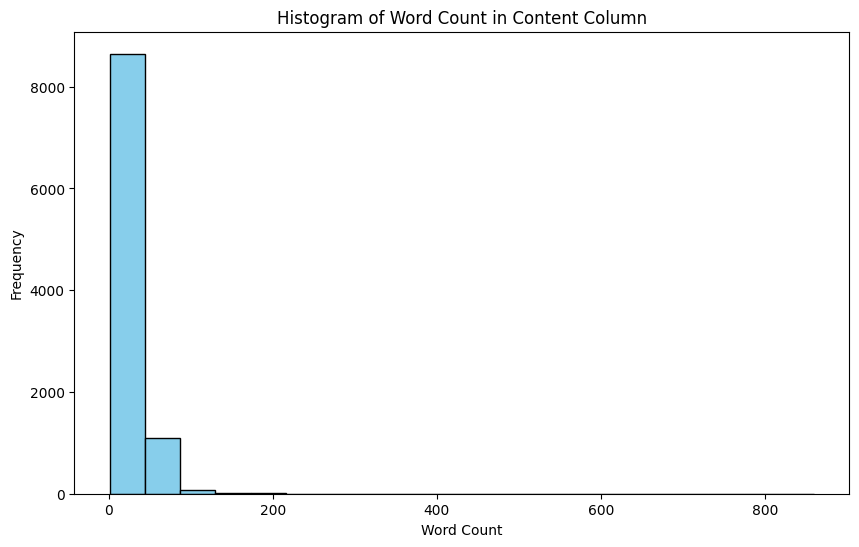

In [9]:
# Calculating the number of words in each content
df['word_count'] = df['content'].apply(lambda x: len(x.split()))

# Plotting the histogram
plt.figure(figsize=(10, 6))
plt.hist(df['word_count'], bins=20, color='skyblue', edgecolor='black')
plt.title('Histogram of Word Count in Content Column')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()

In [10]:
# Calculating the mean and standard deviation of the word count
mean_word_count = df['word_count'].mean()
std_word_count = df['word_count'].std()

mean_word_count, std_word_count

(19.896993092238926, 24.821634467546836)

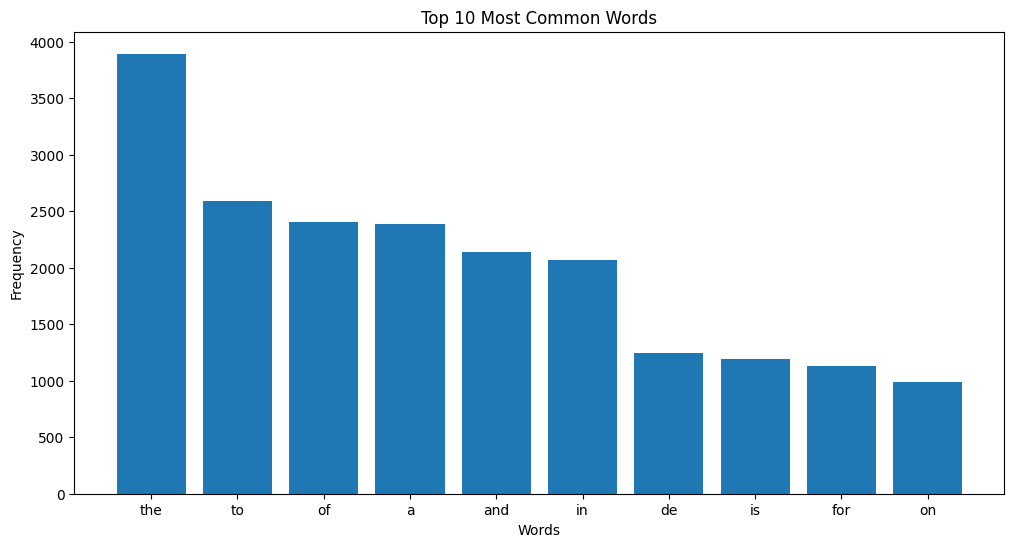

In [16]:
# Extracting all words from the content column
all_words = ' '.join(df['content']).split()

# Counting the frequency of each word
word_counts = Counter(all_words)

# Selecting the top 10 most common words
most_common_words = word_counts.most_common(10)

# Creating a bar chart for the frequency of the most common words
plt.figure(figsize=(12, 6))
plt.bar(*zip(*most_common_words))
plt.title('Top 10 Most Common Words')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.show()

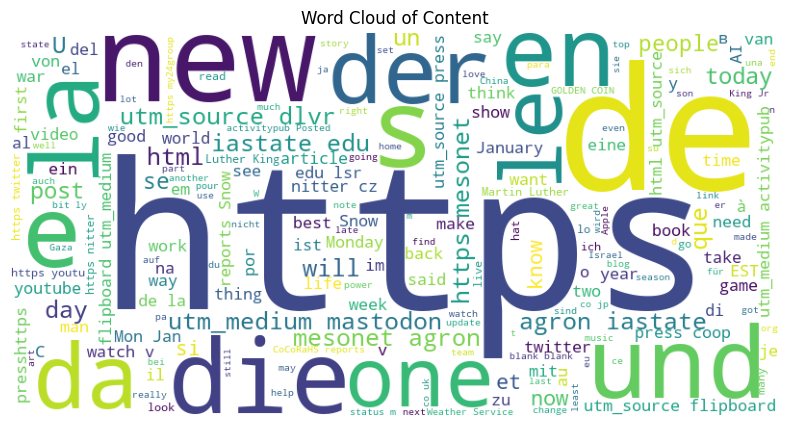

In [17]:
# Creating a word cloud
wordcloud = WordCloud(width = 800, height = 400, background_color ='white').generate(' '.join(all_words))

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud)
plt.axis('off')
plt.title('Word Cloud of Content')
plt.show()

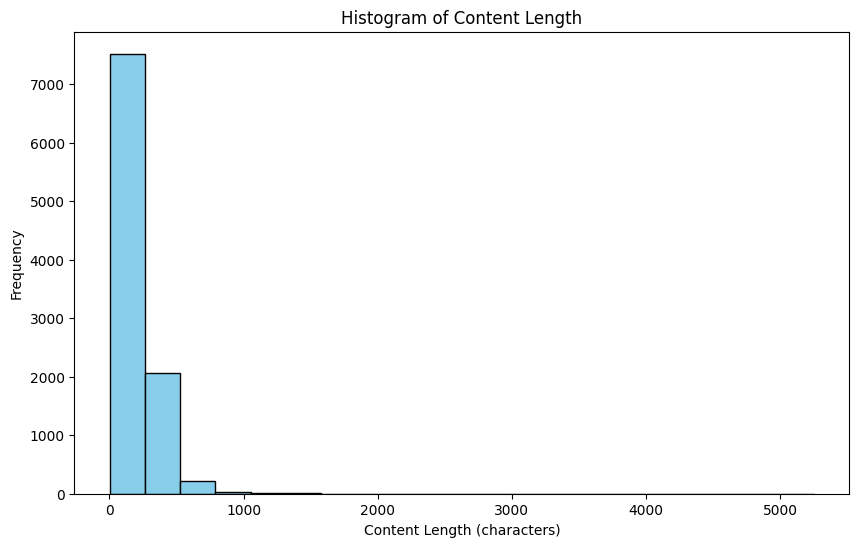

In [18]:
# Calculating the length of each content in characters
df['content_length'] = df['content'].apply(len)

# Creating a histogram for the distribution of content length
plt.figure(figsize=(10, 6))
plt.hist(df['content_length'], bins=20, color='skyblue', edgecolor='black')
plt.title('Histogram of Content Length')
plt.xlabel('Content Length (characters)')
plt.ylabel('Frequency')
plt.show()